In [69]:
# Heuristic polypyrimidine tract model based off relevant criteria.
# I got the idea based off the paper mentioned below. 
# Corvelo A et al (2010) Genome-Wide Association between Branch Point Properties and Alternative Splicing. 
# PLOS Computational Biology 6(11): e1001016. https://doi.org/10.1371/journal.pcbi.1001016

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logomaker


In [19]:
# Train-test split of intronic sequences.
# Pull the sequences you want to train and test on.

DataBase = '/Users/nrk/Desktop/PhD/Database/SpliceSites/'

# 172k
with open(DataBase + 'train3_true.txt') as f: positive_train = list([i.upper() for i in f.read().splitlines() if len(i) == 50])
# 3.4m. A random subset of this will go into the test set, too large.
with open(DataBase + 'train3_null.txt') as f: negative_train = list([i.upper() for i in f.read().splitlines() if len(i) == 50])
# 12k
with open(DataBase + 'test3_true.txt') as f: positive_test = list([i.upper() for i in f.read().splitlines() if len(i) == 50])
# 240k
with open(DataBase + 'test3_null.txt') as f: negative_test = list([i.upper() for i in f.read().splitlines() if len(i) == 50])

In [90]:
# Feature 1: Both 3′ and 5′ ends must be pyrimidines
# Feature 2: No more than three continuous purines are allowed
# Feature 3: Minimum length of 5 nucleotides
# Feature 4: Uridine content greater or equal to 80%.

def heuristic_ppt(sequence):
    
    pyr_pur = sequence.translate(str.maketrans('TCAG', 'YYRR'))

    # Atleast 6 nt long...
    best_ppt = np.zeros((3))
    best = 6
    
    for start_index in range(len(pyr_pur)):
        
        # Looking at windows of atleast 6 nt
        for end_index in range(start_index+1,len(pyr_pur)+1):
            subsequence = pyr_pur[start_index:end_index]
            
            # Starts and ends with pyrimidine
            if subsequence[0] == 'Y' and subsequence[-1] == 'Y':
                
                # No triple purine
                if 'RRR' not in subsequence:
                    
                    # Over a certain % pyrimidine
                    if subsequence.count('Y')/len(subsequence) >= 0.8 :
                        
                        # Favors the earliest PPT
                        if len(subsequence) >= best:
                            best = len(subsequence)
                            best_ppt = [best, start_index, end_index]
                            
    return best_ppt

In [91]:
# Generating Results

num_seq_considered = 10000
foreground_storage = np.zeros((len(positive_train[:num_seq_considered]), 3))
background_storage = np.zeros((len(negative_train[:num_seq_considered]), 3))

for ind, seq in (enumerate(positive_train[:num_seq_considered])):
    foreground_storage[ind] = heuristic_ppt(seq[:-6])

for ind, seq in (enumerate(negative_train[:num_seq_considered])):
    background_storage[ind] = heuristic_ppt(seq[:-6])

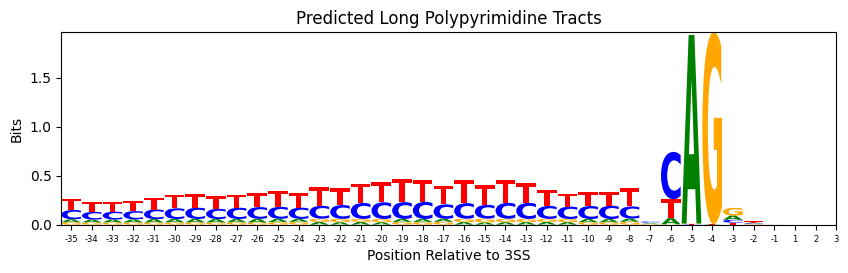

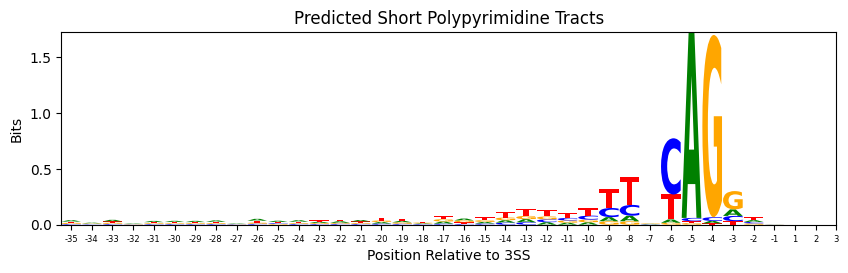

In [92]:
# Sequence logos to visualize results of model

longPPT = logomaker.Logo(logomaker.alignment_to_matrix([true_train3[i[0]].upper()[-35:] for i in np.argwhere(foreground_storage[:,0] > 30)], to_type='information'))

longPPT.style_xticks(size = 6)
longPPT.ax.set_xticks([i for i in range(38)])
longPPT.ax.set_xticklabels([i for i in np.arange(-35,0)] + [1,2,3])
longPPT.ax.set_ylabel('Bits')
longPPT.ax.set_xlabel('Position Relative to 3SS')
longPPT.ax.set_title('Predicted Long Polypyrimidine Tracts')
plt.show()

shortPPT = logomaker.Logo(logomaker.alignment_to_matrix([true_train3[i[0]].upper()[-35:] for i in np.argwhere(foreground_storage[:,0] < 10)], to_type='information'))

shortPPT.style_xticks(size = 6)
shortPPT.ax.set_xticks([i for i in range(38)])
shortPPT.ax.set_xticklabels([i for i in np.arange(-35,0)] + [1,2,3])
shortPPT.ax.set_ylabel('Bits')
shortPPT.ax.set_xlabel('Position Relative to 3SS')
shortPPT.ax.set_title('Predicted Short Polypyrimidine Tracts')
plt.show()

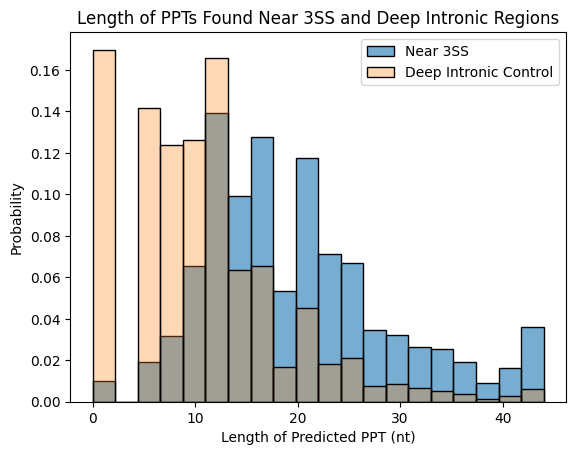

In [121]:
# The length distribution of the polypyrimidine tract near the 3' splice site (Foreground)
# and control, deep intronic regions (Background). 
# Conclusion: PPTs are predicted to have longer tracts near the 3SS.

sns.histplot(foreground_storage[:, 0], bins = 20, alpha = 0.6, stat = 'probability', label = 'Near 3SS')
sns.histplot(background_storage[:, 0], bins = 20, alpha = 0.3, stat = 'probability', label = 'Deep Intronic Control')
plt.xlabel('Length of Predicted PPT (nt)')
plt.title('Length of PPTs Found Near 3SS and Deep Intronic Regions')
plt.legend()
plt.show()

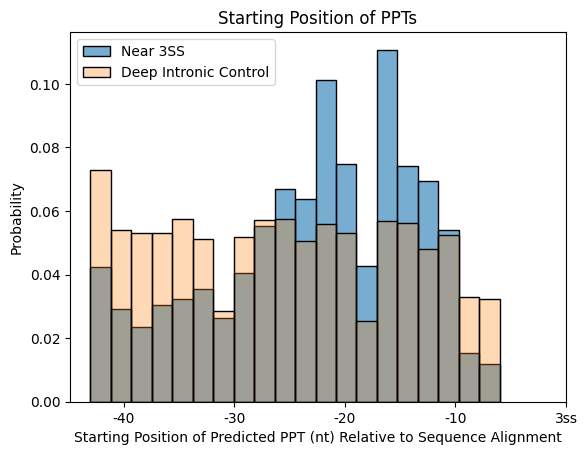

In [159]:
# The positional distribution of the polypyrimidine tract near the 3' splice site (Foreground)
# and control, deep intronic regions (Background). 
# Conclusion: PPTs are predicted more often near splice sites, but uniformly positioned for the deep intronic region. 
# These sequences are aligned, therefore the skew in Near 3SS group is positioned near the splice site.

sns.histplot(foreground_storage[np.where(foreground_storage[:, 1] != 0)[0], 1], bins = 20, alpha = 0.6, stat = 'probability', label = 'Near 3SS')
sns.histplot(background_storage[np.where(background_storage[:, 1] != 0)[0], 1], bins = 20, alpha = 0.3, stat = 'probability', label = 'Deep Intronic Control')
plt.xlabel('Starting Position of Predicted PPT (nt) Relative to Sequence Alignment')
plt.title('Starting Position of PPTs')
plt.xticks(range(4,54,10), ['-40', '-30', '-20', '-10', '3ss'])
plt.legend()
plt.show()